# Dummy variable (no pooling) model for housing prices

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha_{NH[j]} + \beta * log(LA)_i \\
\alpha_j\sim Normal(1, 0.5),\space for\space j = 1...J\space neighbourhoods\\
\beta\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$

In [1]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Train/Test data
train = pd.read_csv('../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

## Load and simulate fake data

In [26]:
no_pooling_model = pystan.StanModel(file = '../models/dummy_variable_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_646ec6a84b9b2478c3ab1d0ef83dcd0e NOW.


In [27]:
npm_data_check = dict(N = len(train),
              log_sales_price = train['log_sales_price_std'],
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = 0.01, 
              beta_sd = 0.1, 
              run_estimation = 0)

fit_npm_check = no_pooling_model.sampling(data=npm_data_check)
npm_df_check = fit_npm_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Prior predictive checks

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1314a09e8>],
      dtype=object)

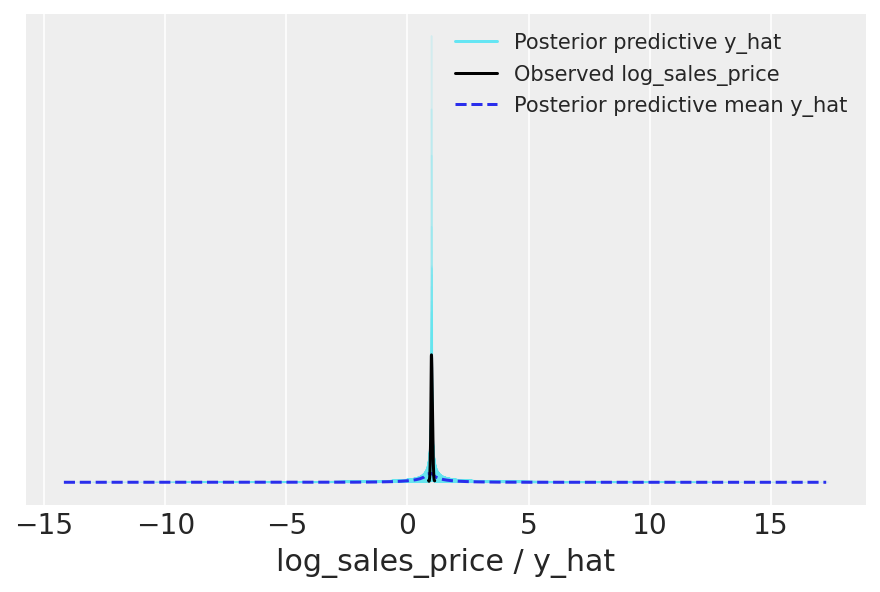

In [7]:
npm_check_az = az.from_pystan(
    posterior=fit_npm_check,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

az.plot_ppc(data = npm_check_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

#az.plot_trace(fit_model_check, var_names=["alpha_j", "beta", "sigma"], compact = True);

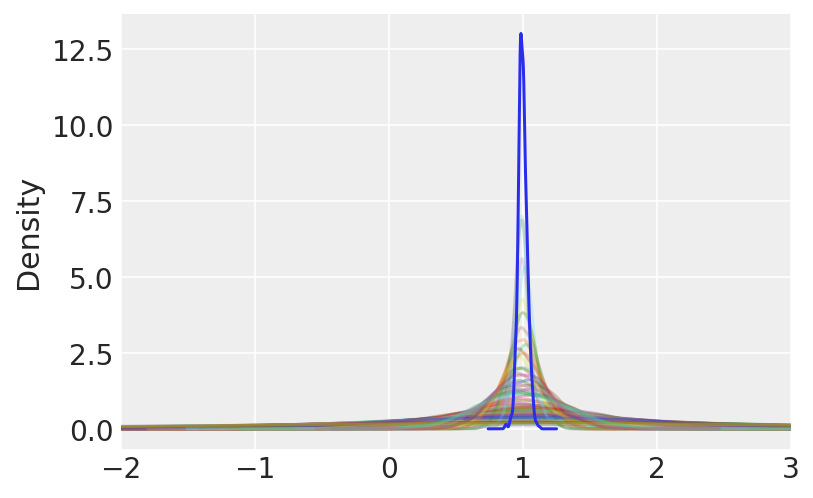

In [11]:
fig, axes = plt.subplots(1,1)

npm_df_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-2, 3),
                                                        ax = axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes);

In [9]:
#az.plot_trace(fit_npm_check, var_names=["alpha", "beta", "sigma"], compact = True);

In [ ]:
## Fit model on fake data and recapture known parameters (appendix?)

## Fit model on real data

In [20]:
npm_data = dict(N = len(train),
              log_sales_price = train['log_sales_price_std'],
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = 0.01, 
              beta_sd = 0.1, 
              run_estimation = 1)

fit_npm = no_pooling_model.sampling(data=npm_data)

npm_az = az.from_pystan(
    posterior=fit_npm,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

fit_npm_df = fit_npm.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


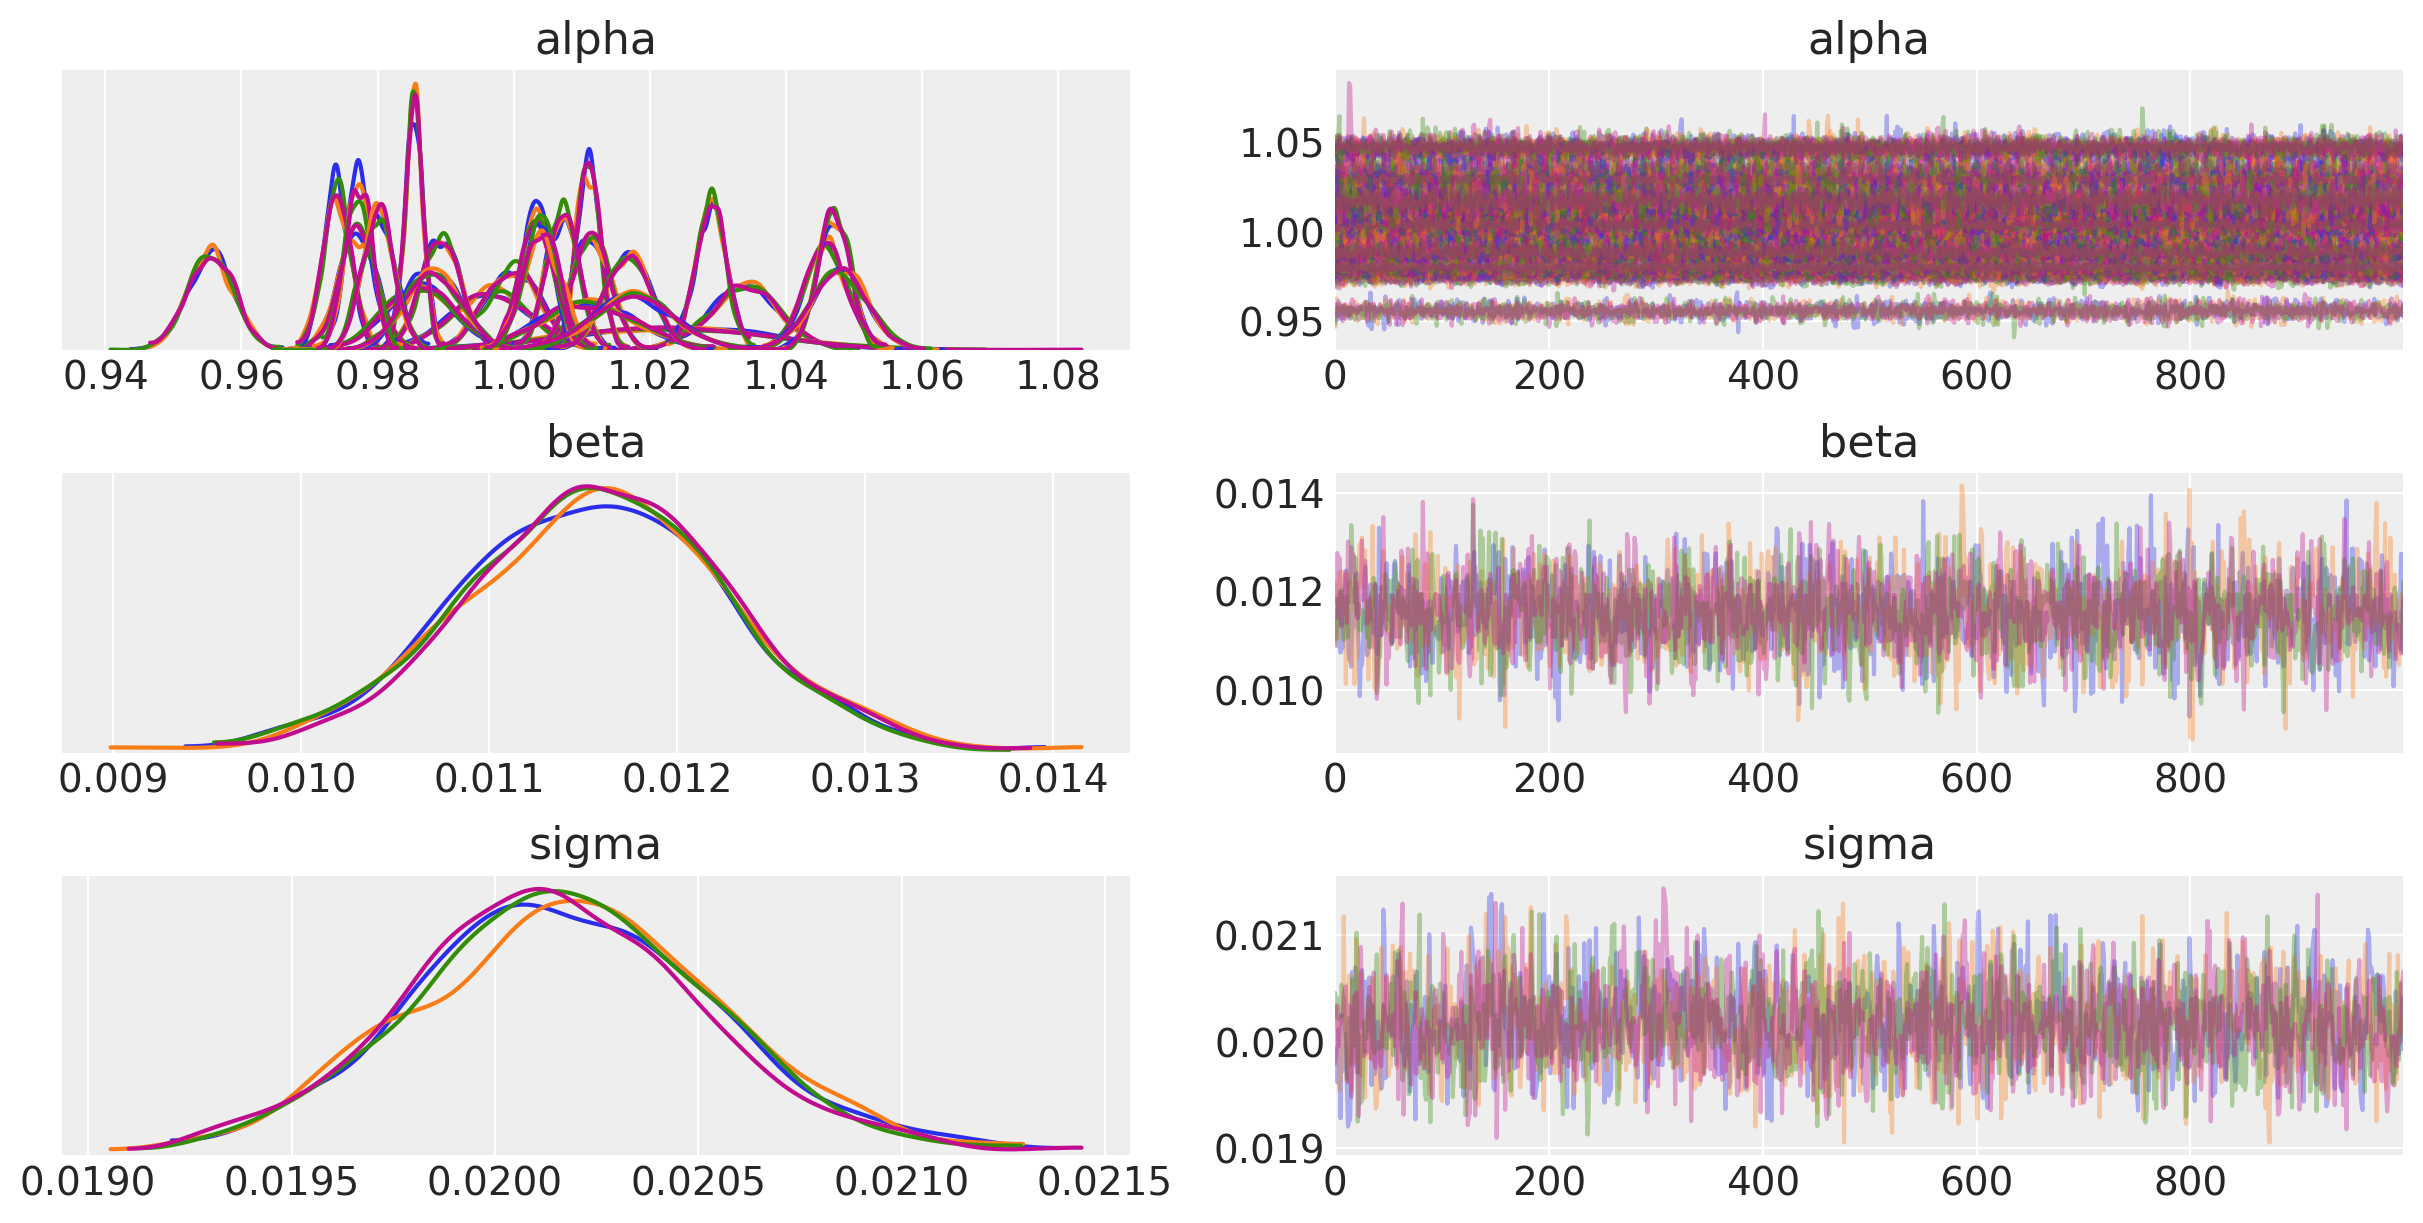

In [230]:
az.plot_trace(fit_npm, var_names=["alpha", "beta", "sigma"], compact = True);

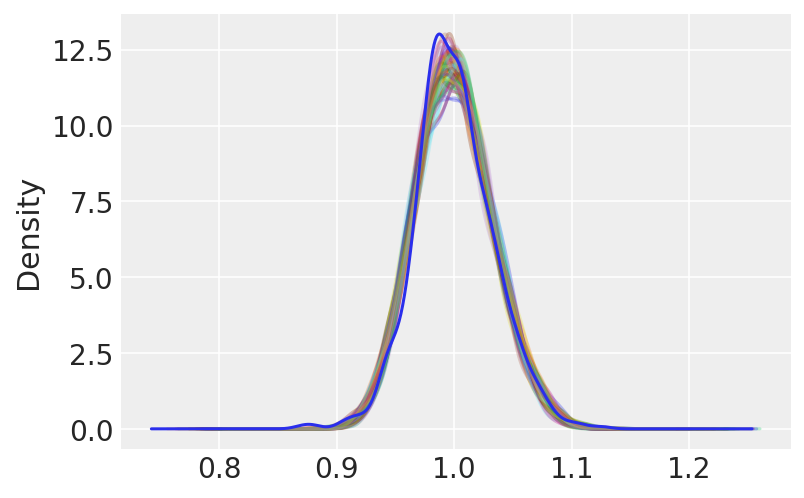

In [16]:
fig, axes = plt.subplots(1,1)

fit_npm_df.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False,
                                                               ax=axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x149051978>],
      dtype=object)

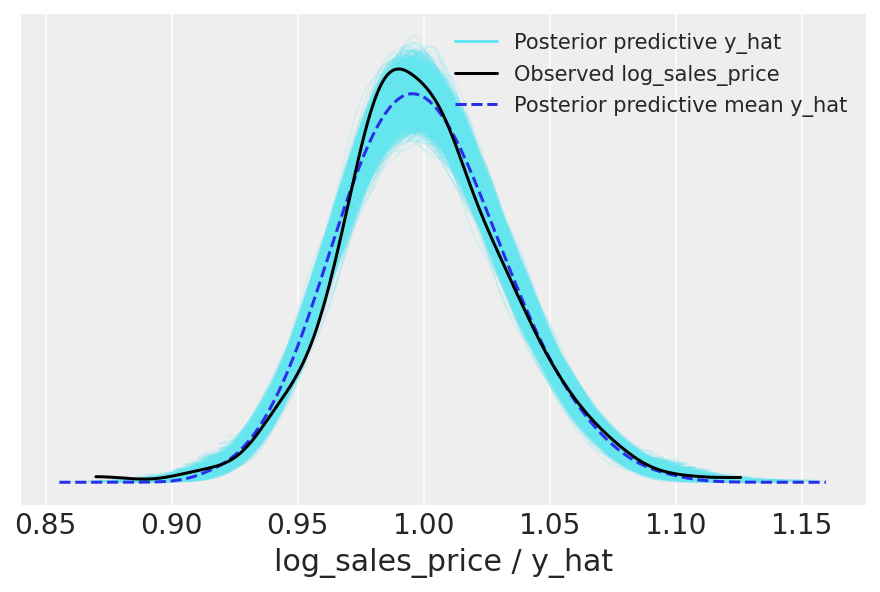

In [15]:
az.plot_ppc(data = npm_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

In [21]:
predictions = pd.DataFrame(np.exp(fit_npm_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

no_pooling_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

no_pooling_csv.to_csv('../data/submissions/dummy_no_pooling.csv', index = False)

In [18]:
%%sh
cd ../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f dummy_no_pooling.csv -m "Dummy variable (no pooling) model"

Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.7k/33.7k [00:05<00:00, 5.89kB/s]
